ETL de Ventas de Videojuegos (Python + pandas + DuckDB)

Los datos siguientes tratados en este cuaderno han sido obtenidos de la fuente pública https://www.kaggle.com/datasets/gregorut/videogamesales

- **Extract**: cargar datos desde CSV.  
- **Transform**: limpieza, normalización, ratios, deduplicados, clasificación por año/plataforma/género.  
- **Load**: salidas en parquet, CSV pequeño y gráficos png y exportar resultados .
- **SQL**: consultas en DuckDB

###  Tecnologías utilizadas
Python · pandas · DuckDB · Matplotlib  

Resultados disponibles en la carpeta `outputs/`.



In [1]:
# Instalación de dependencias (ejecutar solo si no las tienes instaladas en tu entorno)
%pip install -q duckdb pandas matplotlib pyarrow

import os
import pandas as pd
import duckdb
import matplotlib.pyplot as plt


DATA_PATH = "bigdata-ai-portfolio/data/vgsales.csv"
OUTPUT_DIR = "bigdata-ai-portfolio/outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)

pd.set_option("display.max_columns", 100)
pd.set_option("display.width", 120)


Note: you may need to restart the kernel to use updated packages.


In [5]:
# Actualizar pandas para disponer de todas las funcionalidades (ejecutar solo si es necesario)
%pip install --upgrade pandas

Note: you may need to restart the kernel to use updated packages.


In [3]:
# Carga y vista del CSV
df_raw = pd.read_csv(DATA_PATH)

display(df_raw.head())
df_raw.shape, df_raw.dtypes


,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
0,1,Wii Sports,Wii,2006.0,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74
1,2,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24
2,3,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82
3,4,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00
4,5,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37


((16598, 11),
 Rank              int64
 Name             object
 Platform         object
 Year            float64
 Genre            object
 Publisher        object
 NA_Sales        float64
 EU_Sales        float64
 JP_Sales        float64
 Other_Sales     float64
 Global_Sales    float64
 dtype: object)

In [7]:
# Nulos y resumen estadístico
nulls = df_raw.isna().sum().sort_values(ascending=False)
describe = df_raw.describe(include="all")
display(nulls, describe)


Year            271
Publisher        58
Rank              0
Platform          0
Name              0
Genre             0
NA_Sales          0
EU_Sales          0
JP_Sales          0
Other_Sales       0
Global_Sales      0
dtype: int64

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
count,16598.000000,16598,16598,16327.000000,16598,16540,16598.000000,16598.000000,16598.000000,16598.000000,16598.000000
unique,NaN,11493,31,NaN,12,578,NaN,NaN,NaN,NaN,NaN
top,NaN,Need for Speed: Most Wanted,DS,NaN,Action,Electronic Arts,NaN,NaN,NaN,NaN,NaN
freq,NaN,12,2163,NaN,3316,1351,NaN,NaN,NaN,NaN,NaN
mean,8300.605254,NaN,NaN,2006.406443,NaN,NaN,0.264667,0.146652,0.077782,0.048063,0.537441
std,4791.853933,NaN,NaN,5.828981,NaN,NaN,0.816683,0.505351,0.309291,0.188588,1.555028
min,1.000000,NaN,NaN,1980.000000,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.010000
25%,4151.250000,NaN,NaN,2003.000000,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.060000
50%,8300.500000,NaN,NaN,2007.000000,NaN,NaN,0.080000,0.020000,0.000000,0.010000,0.170000
75%,12449.750000,NaN,NaN,2010.000000,NaN,NaN,0.240000,0.110000,0.040000,0.040000,0.470000


In [8]:
#Agregamos reglas a años, ventas, recortes de espacios, mayusculas con sentido, y eliminamos deduplicados
df = df_raw.copy()

for col in ["Name", "Platform", "Genre", "Publisher"]:
    if col in df.columns:
        df[col] = df[col].astype(str).str.strip()

def to_int_or_na(x):
    try:
        xi = int(float(x))
        return xi if 1970 <= xi <= 2030 else pd.NA
    except:
        return pd.NA

if "Year" in df.columns:
    df["Year"] = df["Year"].apply(to_int_or_na).astype("Int64")

sales_cols = ["NA_Sales","EU_Sales","JP_Sales","Other_Sales","Global_Sales"]
for c in sales_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce").fillna(0.0)
        df[c] = df[c].clip(lower=0.0)

before = len(df)
df = df.drop_duplicates(subset=["Name","Platform","Year"], keep="first")
after = len(df)
print(f"Filas antes: {before} | después de deduplicar: {after} | eliminadas: {before-after}")


Filas antes: 16598 | después de deduplicar: 16596 | eliminadas: 2


In [10]:
# Creamos nuevas columnas ventas por región como % del total (cuando Global_Sales > 0) y hacemos un control de calidad de los datos (El global menos la suma de las regiones debe de ser 0 o muy cercana) 
def ratio(a, total):
    return (a / total).where(total > 0)

df["EU_Ratio"] = ratio(df["EU_Sales"], df["Global_Sales"])
df["NA_Ratio"] = ratio(df["NA_Sales"], df["Global_Sales"])
df["JP_Ratio"] = ratio(df["JP_Sales"], df["Global_Sales"])
df["OTH_Ratio"] = ratio(df["Other_Sales"], df["Global_Sales"])


df["Regional_Sum"] = df[["NA_Sales","EU_Sales","JP_Sales","Other_Sales"]].sum(axis=1)
diff = (df["Global_Sales"] - df["Regional_Sum"]).abs().mean()
print(f"Diferencia media |Global - suma regiones|: {diff:.4f}")


Diferencia media |Global - suma regiones|: 0.0027


In [11]:
#Creamos resumenes útiles para análisis (top 10 juegos más vendidos, ventas totales por año, ventas por plataforma(10) y ventas por género)

top10_global = (
    df.sort_values("Global_Sales", ascending=False)
      .loc[:, ["Name","Platform","Year","Genre","Publisher","Global_Sales"]]
      .head(10)
)

sales_by_year = (
    df.dropna(subset=["Year"])
      .groupby("Year", as_index=False)["Global_Sales"]
      .sum()
      .sort_values("Year")
)

sales_by_platform = (
    df.groupby("Platform", as_index=False)["Global_Sales"].sum()
      .sort_values("Global_Sales", ascending=False)
      .head(10)
)

sales_by_genre = (
    df.groupby("Genre", as_index=False)["Global_Sales"].sum()
      .sort_values("Global_Sales", ascending=False)
      .head(10)
)

display(top10_global, sales_by_year.head(), sales_by_platform, sales_by_genre)


,Name,Platform,Year,Genre,Publisher,Global_Sales
0,Wii Sports,Wii,2006,Sports,Nintendo,82.74
1,Super Mario Bros.,NES,1985,Platform,Nintendo,40.24
2,Mario Kart Wii,Wii,2008,Racing,Nintendo,35.82
3,Wii Sports Resort,Wii,2009,Sports,Nintendo,33.00
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,Nintendo,31.37
5,Tetris,GB,1989,Puzzle,Nintendo,30.26
6,New Super Mario Bros.,DS,2006,Platform,Nintendo,30.01
7,Wii Play,Wii,2006,Misc,Nintendo,29.02
8,New Super Mario Bros. Wii,Wii,2009,Platform,Nintendo,28.62
9,Duck Hunt,NES,1984,Shooter,Nintendo,28.31


,Year,Global_Sales
0,1980,11.38
1,1981,35.77
2,1982,28.86
3,1983,16.79
4,1984,50.36


,Platform,Global_Sales
16,PS2,1255.64
28,X360,979.96
17,PS3,957.83
26,Wii,926.69
4,DS,822.49
15,PS,730.66
6,GBA,318.50
19,PSP,296.28
18,PS4,278.10
13,PC,258.82


,Genre,Global_Sales
0,Action,1751.18
10,Sports,1330.92
8,Shooter,1037.35
7,Role-Playing,927.37
4,Platform,831.37
3,Misc,809.96
6,Racing,732.04
2,Fighting,448.91
9,Simulation,392.20
5,Puzzle,244.95


In [13]:
#Aquí de nuevo filtramos datos útiles pero esta vez usando SQL con DuckDB(preferencia mía). Losn resultados muestran los  Top 5 publishers por ventas globales y el ranking anual por plataforma
con = duckdb.connect(database=":memory:")
con.register("games", df)

q1 = """
SELECT Publisher, SUM(Global_Sales) AS total_sales
FROM games
GROUP BY Publisher
ORDER BY total_sales DESC
LIMIT 5
"""
top5_publishers = con.execute(q1).df()

q2 = """
WITH base AS (
  SELECT Year, Platform, SUM(Global_Sales) AS sales
  FROM games
  WHERE Year IS NOT NULL
  GROUP BY Year, Platform
)
SELECT *
FROM (
  SELECT *,
         RANK() OVER (PARTITION BY Year ORDER BY sales DESC) AS rnk
  FROM base
)
WHERE rnk <= 3
ORDER BY Year, rnk;
"""
rank_platform_year = con.execute(q2).df()

display(top5_publishers, rank_platform_year.head(12))


,Publisher,total_sales
0,Nintendo,1786.54
1,Electronic Arts,1110.31
2,Activision,727.46
3,Sony Computer Entertainment,607.50
4,Ubisoft,474.72


,Year,Platform,sales,rnk
0,1980,2600,11.38,1
1,1981,2600,35.77,1
2,1982,2600,28.86,1
3,1983,NES,10.96,1
4,1983,2600,5.83,2
5,1984,NES,50.09,1
6,1984,2600,0.27,2
7,1985,NES,53.44,1
8,1985,2600,0.45,2
9,1985,PC,0.03,3


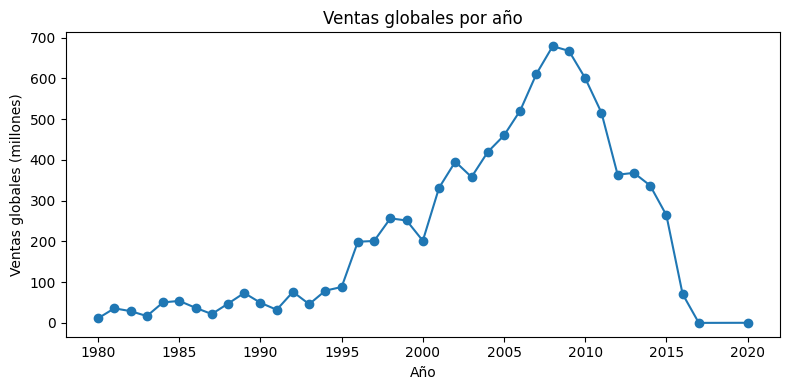

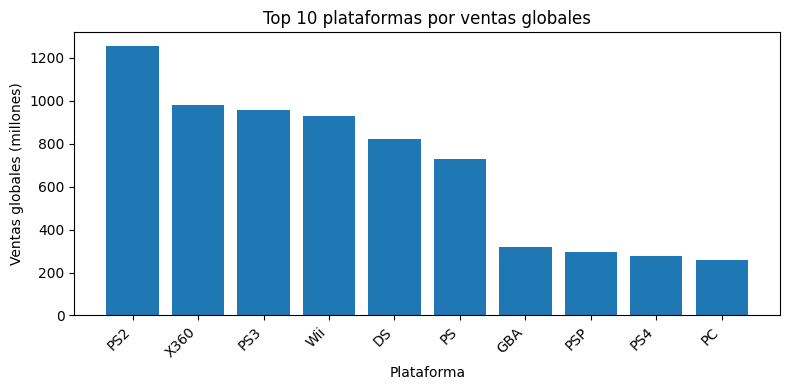

In [14]:
#Creación de gráficos sencillos
plt.figure(figsize=(8,4))
plt.plot(sales_by_year["Year"], sales_by_year["Global_Sales"], marker="o")
plt.title("Ventas globales por año")
plt.xlabel("Año")
plt.ylabel("Ventas globales (millones)")
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/sales_by_year.png", dpi=140)
plt.show()

plt.figure(figsize=(8,4))
plt.bar(sales_by_platform["Platform"], sales_by_platform["Global_Sales"])
plt.title("Top 10 plataformas por ventas globales")
plt.xlabel("Plataforma")
plt.ylabel("Ventas globales (millones)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/sales_by_platform_top10.png", dpi=140)
plt.show()


In [15]:
#Exportar resultados en Parquet(formato Big Data, no visible como texto), CSV y png
clean_parquet = f"{OUTPUT_DIR}/vgsales_clean.parquet"
df.to_parquet(clean_parquet, index=False)

top10_csv = f"{OUTPUT_DIR}/top10_global.csv"
sales_year_csv = f"{OUTPUT_DIR}/sales_by_year.csv"

top10_global.to_csv(top10_csv, index=False)
sales_by_year.to_csv(sales_year_csv, index=False)

print("Guardado:")
print("-", clean_parquet)
print("-", top10_csv)
print("-", sales_year_csv)


Guardado:
- bigdata-ai-portfolio/outputs/vgsales_clean.parquet
- bigdata-ai-portfolio/outputs/top10_global.csv
- bigdata-ai-portfolio/outputs/sales_by_year.csv


In [21]:
#Resumen final y comprobación de validaciones
assert df["Global_Sales"].ge(0).all(), "Hay ventas negativas (no esperado)."
assert df["Global_Sales"].notna().mean() > 0.95, "Demasiados nulos en ventas globales."
assert df["Name"].notna().mean() > 0.99, "Demasiados nombres nulos."

print("Validaciones básicas OK ✅")
print(f"Filas finales: {len(df):,}")
print(f"Años cubiertos: {df['Year'].dropna().astype(int).min()}–{df['Year'].dropna().astype(int).max()}")

Validaciones básicas OK ✅
Filas finales: 16,596
Años cubiertos: 1980–2020


Mini-proyecto de ETL desarrollado por Germán Fraile.